In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
from src.constants import strftime, exch
from src.technicals import calculate_atr
from datetime import datetime, timedelta

from functools import lru_cache

# functions

In [2]:
@lru_cache(maxsize=128)
def get_market_hours(date:str, exchange:str='NYSE') -> tuple:
    if not isinstance(date, str):
        date = date.strftime(strftime)
    schedule = exch.schedule(start_date=date, end_date=date)
    market_open = schedule.at[date, 'market_open']
    market_close = schedule.at[date, 'market_close']
    return market_open, market_close

def get_last_market_day(exchange: str = "NYSE", lookback: int = 7) -> datetime.date:
    today = datetime.today().date()
    nyse = mcal.get_calendar(exchange)
    start_date = today - pd.Timedelta(days=lookback)
    schedule = nyse.schedule(start_date=start_date, end_date=today)
    last_day = schedule.iloc[-1]['market_open'].date()
    if today == last_day:
        return today
    else: 
        return last_day

In [3]:
def reaggregate_bars(df, resample:str='1d') -> pd.DataFrame:
    return pd.DataFrame(
    {
        'Open':df['Open'].resample(resample).first(),
        'High':df['High'].resample(resample).max(),
        'Low':df['Low'].resample(resample).min(),
        'Close':df['Close'].resample(resample).last(),
        'Volume':df['Volume'].resample(resample).sum(),
    }
    ).dropna()

In [4]:
def calculate_tpo(
        df_symbol:pd.DataFrame, 
        session_date:str=get_last_market_day(),
        atr_scaler:float=25.0
    ) -> pd.Series:

    df_daily = reaggregate_bars(df_symbol, '1d')
    df = df_symbol.loc[session_date].copy()
    max_price = df['High'].max().round(2)
    min_price = df['Low'].min().round(2)
    atr = calculate_atr(df_daily).iloc[-1]
    tpo_bin_size = round(atr/atr_scaler, 2)
    bin_edges = np.arange(min_price, max_price + tpo_bin_size, tpo_bin_size)
    bin_labels = bin_edges[:-1]
    tpo_counts = pd.Series(0, index=bin_labels)
    for _, row in df.iterrows():
        low = row['Low']
        high = row['High']
        price_range = np.arange(low, high + tpo_bin_size, tpo_bin_size)
        binned = pd.cut(price_range, bins=bin_edges, labels=bin_labels, right=False)
        binned = binned.dropna().unique()
        for bin_label in binned:
            tpo_counts[bin_label] += 1
    return tpo_counts

In [5]:
def calculate_value_area(tpo_counts:pd.Series, value_area_pct:float=0.7) -> dict:
    sorted_tpo = tpo_counts.sort_values(ascending=False)
    total_tpos = sorted_tpo.sum()
    target_tpos = total_tpos * value_area_pct
    max_count = sorted_tpo.iloc[0]
    poc_candidates = sorted_tpo[sorted_tpo == max_count].index
    price_center = np.average(tpo_counts.index, weights=tpo_counts.values)
    poc = min(poc_candidates, key=lambda x: abs(x - price_center))  # closest to center
    value_area_bins = [poc]
    cumulative = tpo_counts[poc]
    remaining = tpo_counts.drop(index=poc) # remove POC bin
    sorted_bins = sorted(remaining.index)
    bin_size = sorted_bins[1] - sorted_bins[0]
    above = poc + bin_size
    below = poc - bin_size

    while cumulative < target_tpos:
        next_bins = []
        if above in remaining:
            next_bins.append((above, tpo_counts[above]))
        if below in remaining:
            next_bins.append((below, tpo_counts[below]))

        if not next_bins:
            break

    # Choose the bin with higher TPO count; if tied, prefer lower price
        next_bins.sort(key=lambda x: (-x[1], x[0]))
        chosen_price, count = next_bins[0]

        value_area_bins.append(chosen_price)
        cumulative += count
        remaining = remaining.drop(index=chosen_price)

        # Move pointers
        if chosen_price == above:
            above += bin_size
        else:
            below -= bin_size

    val = min(value_area_bins)
    vah = max(value_area_bins)

    return {
        'POC':round(poc,2),
        'VAH':round(vah,2),
        'VAL':round(val,2),
        # 'Value Area Bins': sorted(value_area_bins),
        # 'Total TPOs': total_tpos,
        # 'Captured TPOs': cumulative
    }

In [6]:
def calculate_initial_balance(df_session:pd.DataFrame) -> tuple:
    ib_low = df_session[df_session['First Hour']]['Low'].min()
    ib_high = df_session[df_session['First Hour']]['High'].max()
    return ib_low, ib_high

def calculate_session_high_low_close(df_session:pd.DataFrame) -> tuple:
    session_high = df_session['High'].max()
    session_low = df_session['Low'].min()
    session_close = df_session.iloc[-1]['Close']
    return session_high, session_low, session_close

def rank_momentum(df_current_session:pd.DataFrame, va_current:dict, va_previous:dict) -> tuple:
    session_high, session_low, session_close = calculate_session_high_low_close(df_current_session)
    ib_low, ib_high = calculate_initial_balance(df_current_session)
    opening = rank_opening(session_high, session_low, ib_low, ib_high, va_previous)
    extension = rank_extension(session_high, session_low, ib_low, ib_high, va_previous)
    closing = rank_closing(session_close, va_current)
    return opening, extension, closing


def rank_opening(session_high, session_low, ib_low, ib_high, va_previous):
    rank = 0.0
    # bullish
    if (ib_low == session_low) & (ib_high != session_high):
        if session_low > va_previous['VAH']:
            rank = 4.0
        elif (session_low <= va_previous['VAH']) & (session_low > va_previous['POC']):
            rank = 3.0
        elif (session_low <= va_previous['POC']) & (session_low >= va_previous['VAL']):
            rank = 2.0
        elif session_low < va_previous['VAL']:
            rank = 1.0

    # bearish
    elif (ib_high == session_high) & (ib_low != session_low):
        if session_high < va_previous['VAL']:
            rank = -4.0
        elif (session_high >= va_previous['VAL']) & (session_high < va_previous['POC']):
            rank = -3.0
        elif (session_high >= va_previous['POC']) & (session_high <= va_previous['VAH']):
            rank = -2.0
        elif session_high >= va_previous['VAH']:
            rank = -1.0

    # session high and low made in first hour        
    elif (ib_high == session_high) & (ib_low == session_low):
        rank = 0.0
    return rank

def rank_extension(session_high, session_low, ib_low, ib_high, va_previous) -> float:
    rank = 0.0
    # bullish
    if (session_high > ib_high):
        if session_high > va_previous['VAH']:
            rank = 4.0
        elif (session_high <= va_previous['VAH']) & (session_high > va_previous['POC']):
            rank = 3.0
        elif (session_high <= va_previous['POC']) & (session_high >= va_previous['VAL']):
            rank = 2.0
        elif session_high < va_previous['VAL']:
            rank = 1.0
    # bearish
    elif (session_low < ib_low):
        if session_low < va_previous['VAL']:
            rank = -4.0
        elif (session_low >= va_previous['VAL']) & (session_low < va_previous['POC']):
            rank = -3.0
        elif (session_low >= va_previous['POC']) & (session_low <= va_previous['VAH']):
            rank = -2.0
        elif (session_low > va_previous['VAH']):
            rank = -1.0 
    return rank

def rank_closing(session_close, va_current) -> float:
    rank = 0.0
    # bullish
    if session_close > va_current['VAH']:
        rank = 3.0
    elif session_close == va_current['VAH']:
        rank = 2.0
    elif session_close > va_current['POC']:
        rank = 1.0
    # neutral
    elif session_close == va_current['POC']:
        rank = 0.0
    # bearish
    elif session_close > va_current['VAL']:
        rank = -1.0
    elif session_close == va_current['VAL']:
        rank = -2.0
    elif session_close < va_current['VAL']:
        rank = -3.0
    return rank

# Testing

In [7]:
with open('files/watchlist.txt') as f:
    watchlist = f.read().split(' ')
last_market_day = get_last_market_day()
# last_market_day = datetime.strptime('2024-02-05', strftime)
starting_day = last_market_day - timedelta(days=30)

In [8]:
df_raw = yf.download(
    watchlist, 
    auto_adjust=False, 
    interval='30m', 
    start=starting_day,
    end=last_market_day + timedelta(days=1),
    group_by='ticker'
)

[*********************100%***********************]  89 of 89 completed


In [9]:
results = dict()
available_dates = pd.Series(df_raw.index.date).sort_values(ascending=True).unique().tolist()
for i, symbol in enumerate(watchlist):
    results[symbol] = dict()
    df_symbol = df_raw[symbol].copy()
    first_hour = []
    last_half_hour = []
    for date in available_dates:
        opening_bell, closing_bell = get_market_hours(date)
        first_hour.append(opening_bell)
        first_hour.append(opening_bell+timedelta(minutes=30))
        last_half_hour.append(closing_bell-timedelta(minutes=30))
    df_symbol['First Hour'] = False
    df_symbol['Last Half Hour'] = False
    df_symbol.loc[first_hour, 'First Hour'] = True
    df_symbol.loc[last_half_hour, 'Last Half Hour'] = True
    value_areas = dict()
    
    for date in available_dates:
        current_date = date.strftime(strftime)
        previous_date = (date - timedelta(days=1)).strftime(strftime)
        tpo = calculate_tpo(df_symbol, current_date)
        value_areas[current_date] = calculate_value_area(tpo)
        if previous_date in value_areas:
            results[symbol][current_date] = dict()
            df_session = df_symbol.loc[current_date].copy()
            
            opening_rank, extension_rank, closing_rank = rank_momentum(df_session, value_areas[current_date], value_areas[previous_date])
            results[symbol][current_date]['Opening Rank'] = opening_rank
            results[symbol][current_date]['Extension Rank'] = extension_rank
            results[symbol][current_date]['Closing Rank'] = closing_rank
            results[symbol][current_date]['Total Rank'] = opening_rank + extension_rank + closing_rank
            # results[symbol][current_date]['Value Area'] = value_areas[current_date]


In [11]:
df_results = pd.concat({
    symbol: pd.DataFrame.from_dict(inner_dict, orient='index')
    for symbol, inner_dict in results.items()
}, axis=1)

In [ ]:
# Find stocks with >= 3 sessions between +/- 5 ==> watch for breakout
# Find stocks with >= 3 sessions above or below +/- 9 ==> watch for exhaustion

In [ ]:
threshold = 9
signals = dict()
for symbol in watchlist:
    symbol_rank = df_results[symbol]['Total Rank']
    last_rank = symbol_rank.loc[current_date]
    if (last_rank >= threshold):
        signals[f"{symbol}:bull"] = df_results[symbol]['Total Rank']
    elif (last_rank <= -threshold):
        signals[f"{symbol}:bear"] = df_results[symbol]['Total Rank']
    elif symbol_rank.iloc[-3:].between(-5, 5).all():
        signals[f"{symbol}:breakout"] = df_results[symbol]['Total Rank']

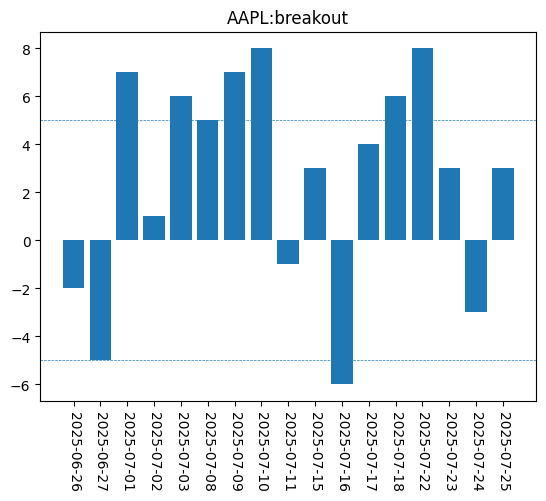

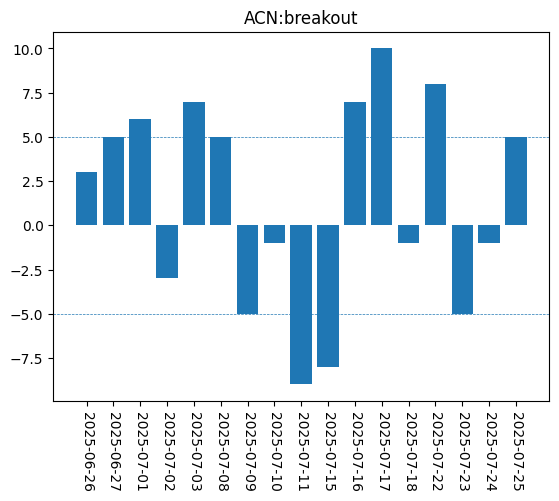

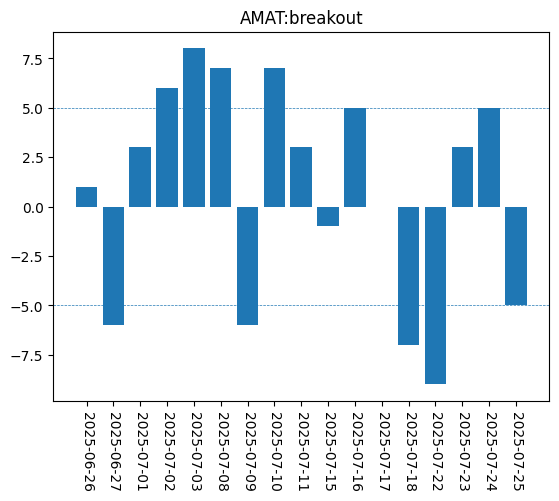

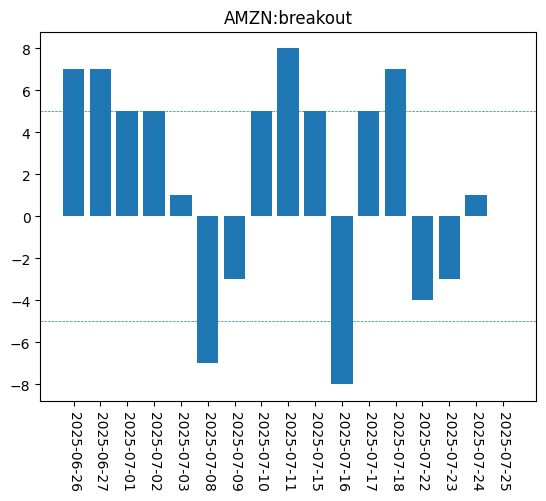

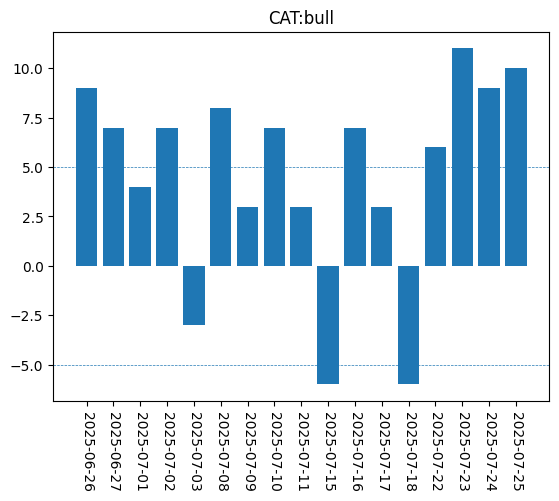

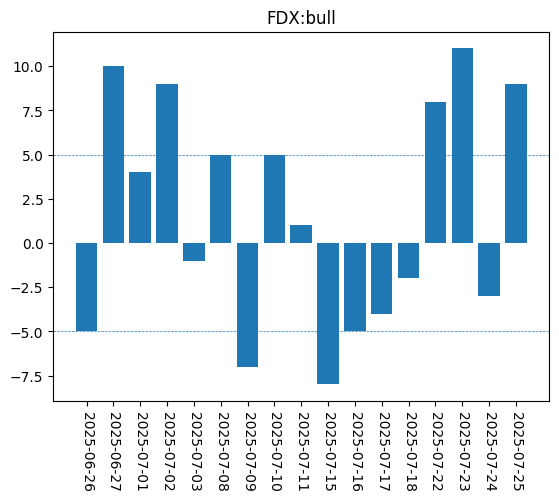

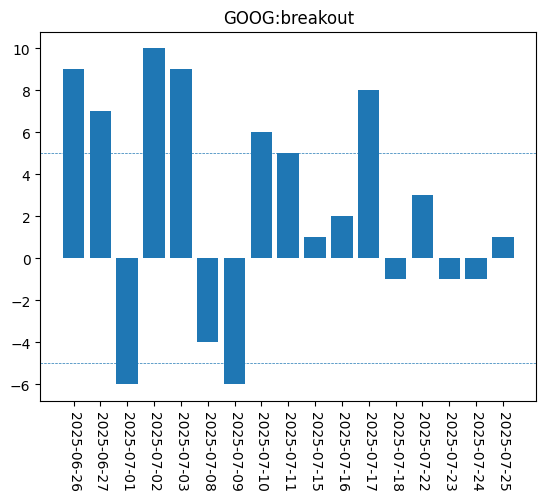

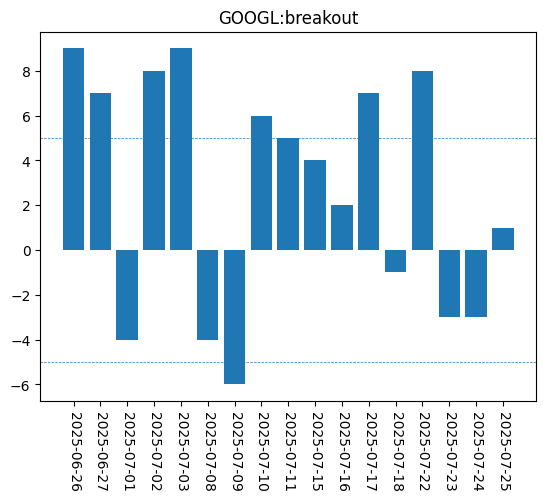

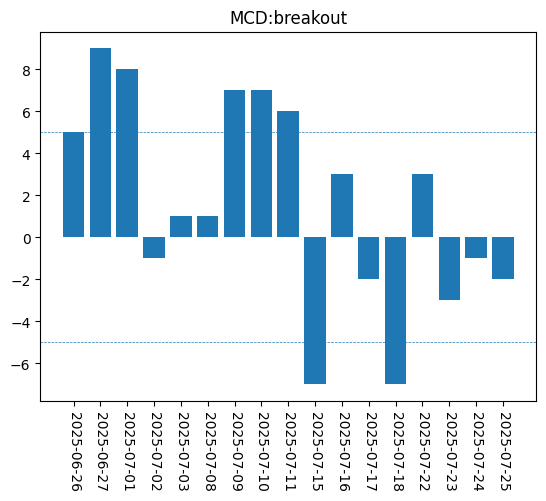

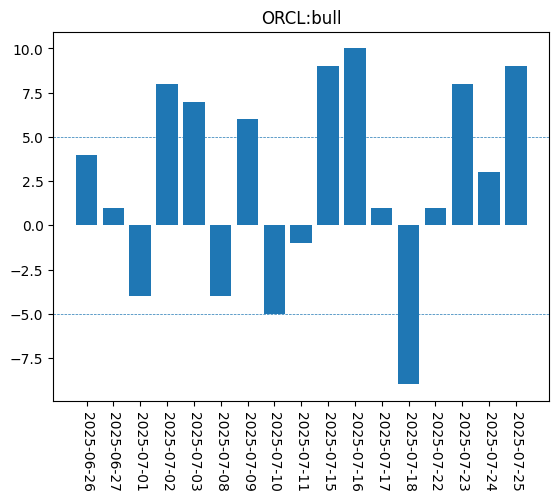

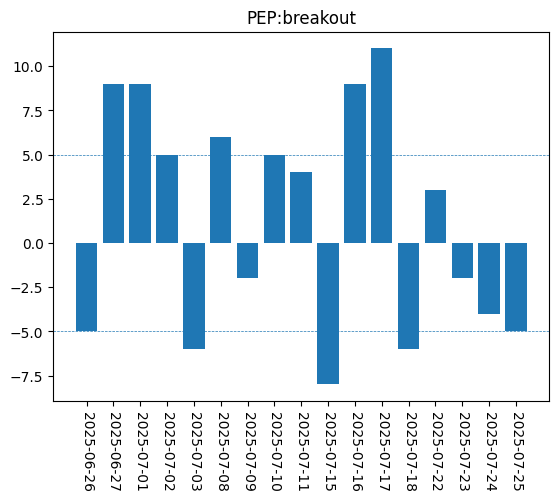

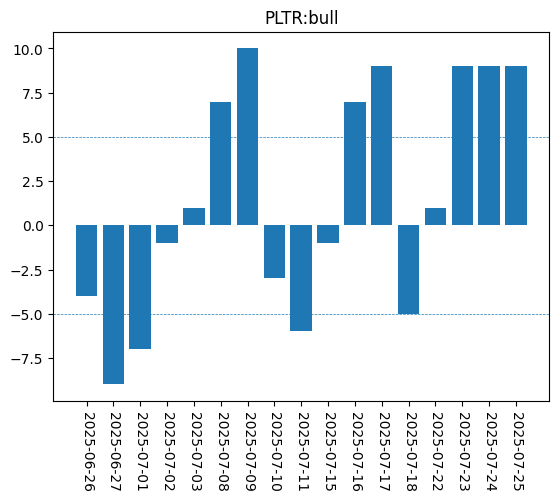

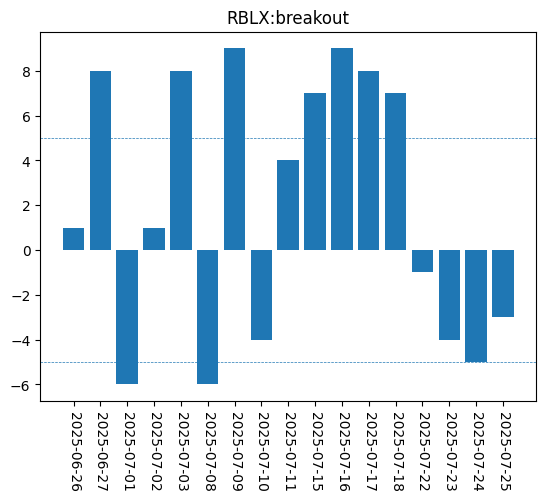

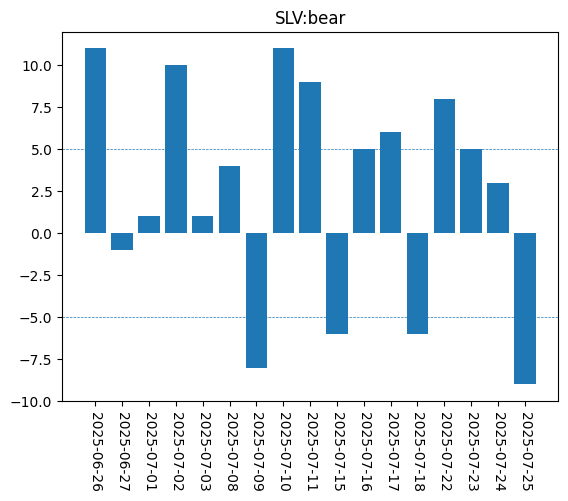

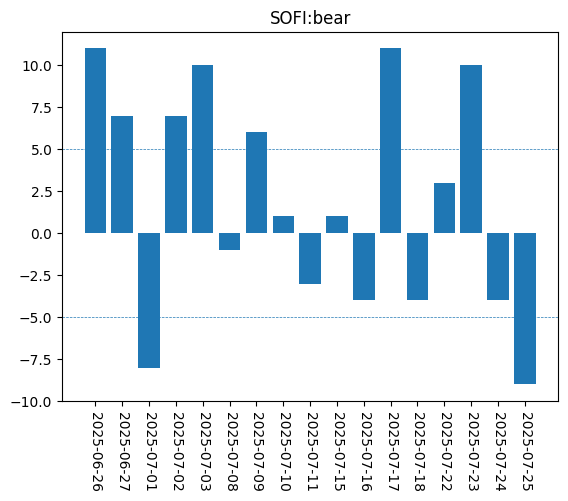

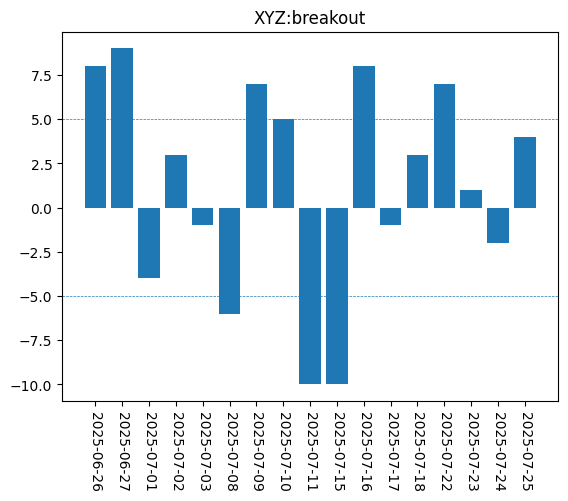

In [53]:
df_signals = pd.DataFrame(signals)
for symbol in df_signals.columns:
    plt.bar(x=df_signals.index, height=df_signals[symbol],)
    plt.xticks(rotation=-90)
    plt.title(symbol)
    plt.axhline(y=5, xmin=0, xmax=len(df_signals), linestyle='--', linewidth=0.5)
    plt.axhline(y=-5, xmin=0, xmax=len(df_signals), linestyle='--', linewidth=0.5)
    plt.show()

In [14]:
# "backtest" of sorts

threshold = 11
backtest_results = dict()
result_counter = {'Bull wins':0, 'Bull misses':0, 'Bear wins':0, 'Bear misses':0}
for symbol in watchlist:
    backtest_results[symbol] = {}
    df_symbol = df_raw[symbol].copy()
    symbol_result = df_results[symbol]
    bull_signal_days = symbol_result[((symbol_result['Opening Rank'] > 0) & (symbol_result['Extension Rank'] > 0) & (symbol_result['Closing Rank'] > 0) & (symbol_result['Total Rank'] >= threshold))].index.tolist()
    bear_signal_days = symbol_result[((symbol_result['Opening Rank'] < 0) & (symbol_result['Extension Rank'] < 0) & (symbol_result['Closing Rank'] < 0) & (symbol_result['Total Rank'] <= threshold))].index.tolist()
    for day in bull_signal_days + bear_signal_days:
        day_index = available_dates.index(datetime.strptime(day, strftime).date())
        if  day_index < len(available_dates) - 1:
            backtest_results[symbol][day] = {}
            next_day = available_dates[day_index + 1].strftime(strftime)
            signal_day_close = df_symbol.loc[day]['Close'].sort_index().iloc[-1]
            next_day_close = df_symbol.loc[next_day]['Close'].sort_index().iloc[-1]
            backtest_results[symbol][day]['signal_day_close'] = float(round(signal_day_close,2))
            backtest_results[symbol][day]['next_day_close'] = float(round(next_day_close,2))
            if day in bull_signal_days:
                backtest_results[symbol][day]['signal'] = 'bull'
                if next_day_close > signal_day_close:
                    result_counter['Bull wins'] += 1
                else:
                    result_counter['Bull misses'] += 1

            elif day in bear_signal_days:
                backtest_results[symbol][day]['signal'] = 'bear'
                if next_day_close < signal_day_close:
                    result_counter['Bear wins'] += 1
                else:
                    result_counter['Bear misses'] += 1
            

            
result_counter

{'Bull wins': 15, 'Bull misses': 25, 'Bear wins': 99, 'Bear misses': 169}